# C aceto GSM gsmodutils test suite

This notebook demonstrates C. autoethanogenum GSM tests and analysis (Norman et al., 2018).
Th

Click on cells and press 'run' to view results this requires COBRApy (https://opencobra.github.io/cobrapy/) and gsmodutils (https://github.com/sbrcnottingham/gsmodutils)

This notebook first shows usage of the command line tools to run the project's validation tests.
The next section of the notebook shows how to use python to interact with the models.

For a more featured tutorial, refer to the gsmodutils documentation at http://gsmodutils.readthedocs.io




### Using the command line tools for gsmodutils
First we view the project and run the tests with the gsmodutils command line interface.
The info command below first shows us all the models (top level gsms), designs (additional reactions or constraints to apply to models) and conditions  (growth media settings) associated with the project.

In [2]:
!command gsmodutils info

--------------------------------------------------------------------------------
Project description - Clostridium auto (Nottingham/Brookes)
Author(s): - Rupert Norman
Author email - rupert.norman@nottingham.ac.uk
Designs directory - designs
Tests directory - tests   
    
Models:
	* metaclau.json
		 metaclau
Designs:
********************************************************************************
	* flux minimisation fluxm_flux_minimisation
		 
    Minimisation of flux accross reactions as objective function
    minimize absolute sum of enzyme-catalysed network flux (Row 1 of Table 3 in manuscript)
    
********************************************************************************
	* flux minimisation h2 rest fluxm_flux_minimisation_h2_restricted
	Parent: fluxm_flux_minimisation
		
    flux minimisation with h2 restriction
    
********************************************************************************
Conditions:
		No growth conditions found
-----------------------------------

The test command runs the default tests, ensuring that all models, designs and conditions load and grow as specified.
The command then also runs the custom JSON and Python tests found in the tests folder.

This should show which aspects of models run correctly. Carefully designed tests will hilight when modelling errors occurs.
This is particularly important for propagating models.

The designs are loaded from python files in the designs folder of the project, with tests being loaded from the test folder.

Here we use verbose mode which shows all the success tests with their conditions.

In [3]:
!command gsmodutils test

------------------------- gsmodutils test results -------------------------
Running tests: 
100%|███████████████████████████████████████████| 10/10 [00:28<00:00,  2.87s/it]

Default project file tests (models, designs, conditions):
Counted 3 test assertions with 0 failures
Project file completed all tests without error
    --model_metaclau.json

    --design_fluxm_flux_minimisation

    --design_fluxm_flux_minimisation_h2_restricted

Test file test_defaults.py:
Counted 517 test assertions with 8 failures
Test file has test errors
    --test_atpase_validity
        --('metaclau.json', 'fluxm_flux_minimisation')

        --('metaclau.json', 'fluxm_flux_minimisation_h2_restricted')

        --metaclau.json


    --test_acetate

    --test_minimisation_reactions
        --('metaclau.json', 'fluxm_flux_minimisation')

        --('metaclau.json', 'fluxm_flux_minimisation_h2_restricted')


    --test_minimisation_fluxm_products
        --('metaclau.json', 'fluxm_flux_minimisation')


    --te

## Using the python interface

Alternatively we can run the tests with python an load the logs with the test log viewer.
The returned object is a dictionary showing the status of all tests and their children (assertions made in tests).

In [25]:
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import json
import cobra
import gsmodutils
project = gsmodutils.GSMProject()

test_logs = project.run_tests() # Test_logs is just a dictionary storing the above results

100%|██████████| 10/10 [00:27<00:00,  2.77s/it]


### Performing analysis (loading designs and models)
We would like to perform more indepth analysis with our models. The following sections highlight some of the results presented in the initial C aceto genom scale model paper (Norman et al. 2018).

We load the model with the project context.

The summary should show that the model grows on CO and produces Biomass with carbon dioxide and acetate among the products for conventional FBA using Biomass as the model objective. 

In [6]:
model = project.load_model()

model.summary()

IN FLUXES                   OUT FLUXES                 OBJECTIVES
--------------------------  -------------------------  ------------------
x_CARBON-MON...  10         x_CARBON-DIO...  5.04      EX_BIOMASS  0.0106
x_WATER           4.77      x_ACET           2.31
x_AMMONIA         0.0731    x_PROTON         2.28
x_Pi              0.0627    x_PPI            0.0194
x_HS              0.0018    x_BIOMASS        0.0106
x_NIACINE         0.000958  x_ADENOSYL-H...  0.000636
                            x_GLYCOL         0.000451


Next, we would like to load one of the designs that alters the constraints of the model to allow different behaviour.
The first example of this is to use the minimisation of flux accross enzymatic reaction methods (commonly used by scrumpy) also often known as parsimonious FBA.

To do this we load the design, we then look at the solution this produces.

In [12]:
model = project.load_design("fluxm_flux_minimisation")
sol = model.optimize()
v = sol.fluxes

print('acetate:',v['EX_ACET'])
print('ethanol:',v['EX_ETOH'])
print('CO2:',v['EX_CARBON-DIOXIDE'])
print('CO:',v['EX_CARBON-MONOXIDE'])


acetate: 0.061787589248978314
ethanol: 2.690969301995662
CO2: 12.023437903930102
CO: -18.43954304598722


Now we would like perform a flux scan, altering the level of CO as the carbon source and understanding how the products change.

cobra/util/solver.py:403 UserWarning: solver status is 'infeasible'


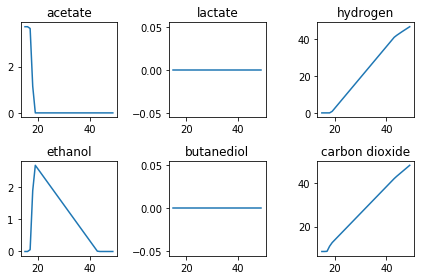

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt

model = project.load_design("fluxm_flux_minimisation")

v_acetate = [] ; v_ethanol = [] ; v_lactate = [] ; v_butanediol = [] ; v_hydrogen = [] ; v_CO2 = []


co_uptake_range = np.arange(15,50,1) #define range of co uptake fluxes (args: start, stop, step)
#fba scan
for co_uptake in co_uptake_range:
    model.reactions.get_by_id('EX_CARBON-MONOXIDE').bounds = (-co_uptake,-co_uptake)
    sol = model.optimize()
    v = sol.fluxes
    v_acetate.append(v['EX_ACET'])
    v_ethanol.append(v['EX_ETOH'])
    v_lactate.append(v['EX_D-LACTATE'])
    v_butanediol.append(v['EX_BUTANEDIOL'])
    v_hydrogen.append(v['EX_HYDROGEN-MOLECULE'])
    v_CO2.append(v['EX_CARBON-DIOXIDE'])

#plot co uptake vs. products
fig, ax = plt.subplots(2,3)
ax[0,0].plot(co_uptake_range,v_acetate)
ax[0,0].set_title('acetate')

ax[1,0].plot(co_uptake_range,v_ethanol)
ax[1,0].set_title('ethanol')

ax[0,1].plot(co_uptake_range,v_lactate)
ax[0,1].set_title('lactate')

ax[1,1].plot(co_uptake_range,v_butanediol)
ax[1,1].set_title('butanediol')

ax[0,2].plot(co_uptake_range,v_hydrogen)
ax[0,2].set_title('hydrogen')

ax[1,2].plot(co_uptake_range,v_CO2)
ax[1,2].set_title('carbon dioxide')

plt.tight_layout()

This shows that the hydrogen output increaseas as a product of the increased Carbon monoxide uptake. However, products such as butanediol and lactate are not products.

When restricting the hydrogen exporter we find different results:

cobra/util/solver.py:403 UserWarning: solver status is 'infeasible'


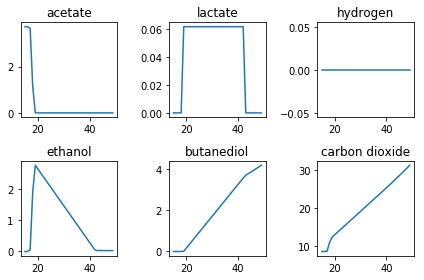

In [23]:
model = project.load_design('fluxm_flux_minimisation_h2_restricted')
v_acetate = [] ; v_ethanol = [] ; v_lactate = [] ; v_butanediol = [] ; v_hydrogen = [] ; v_CO2 = []


co_uptake_range = np.arange(15,50,1) #define range of co uptake fluxes (args: start, stop, step)
#fba scan
for co_uptake in co_uptake_range:

    model.reactions.get_by_id('EX_CARBON-MONOXIDE').bounds = (-co_uptake,-co_uptake)
    sol = model.optimize()
    v = sol.fluxes
    v_acetate.append(v['EX_ACET'])
    v_ethanol.append(v['EX_ETOH'])
    v_lactate.append(v['EX_D-LACTATE'])
    v_butanediol.append(v['EX_BUTANEDIOL'])
    v_hydrogen.append(v['EX_HYDROGEN-MOLECULE'])
    v_CO2.append(v['EX_CARBON-DIOXIDE'])

#plot co uptake vs. products
fig, ax = plt.subplots(2,3)
ax[0,0].plot(co_uptake_range,v_acetate)
ax[0,0].set_title('acetate')

ax[1,0].plot(co_uptake_range,v_ethanol)
ax[1,0].set_title('ethanol')

ax[0,1].plot(co_uptake_range,v_lactate)
ax[0,1].set_title('lactate')

ax[1,1].plot(co_uptake_range,v_butanediol)
ax[1,1].set_title('butanediol')

ax[0,2].plot(co_uptake_range,v_hydrogen)
ax[0,2].set_title('hydrogen')

ax[1,2].plot(co_uptake_range,v_CO2)
ax[1,2].set_title('carbon dioxide')

plt.tight_layout()


The above plots show similar behaviour for acetate and ethanol and CO2 production, but we can see that the lactate and butanediol production occurs as the cell needs to find a way to export excess hydrogen. 

## Conclusion

This notebook has shown how to use gsmodutils in two standard forms, firstly to view project info of an existing project and to run a set of resuable tests on existing genome scale models and strain designs.
Secondly, we showed how the python interface of gsmodutils can be used to interface with these strain designs to perform different forms of flux balance analysis.
The analysis shows that the genome scale model replicates the clostridium acetobutylicum behaviour under hydrogen limiting conditons to produce lactate and butanediol.
This code can easily be adapted to create new designs and analysis.
